In [ ]:
import pandas as pd


df = pd.read_csv("data/merged.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")
df["date"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour




In [3]:
# Pivot precipitation
pr_daily = df.pivot(index="date", columns="hour", values="pr")
pr_daily.columns = [f"pr_{h:02d}" for h in pr_daily.columns]

# Pivot discharge
Q_daily = df.pivot(index="date", columns="hour", values="Q")
Q_daily.columns = [f"Q_{h:02d}" for h in Q_daily.columns]


In [4]:
daily = pd.concat([pr_daily, Q_daily], axis=1)
daily = daily.dropna().reset_index()
daily

,date,pr_00,pr_01,pr_02,pr_03,pr_04,pr_05,pr_06,pr_07,pr_08,...,Q_14,Q_15,Q_16,Q_17,Q_18,Q_19,Q_20,Q_21,Q_22,Q_23
0,1995-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,14.868509,14.834859,14.801210,14.767560,14.733910,14.700260,14.666611,14.632961,14.599311,14.565662
1,1995-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,14.060916,14.027266,13.993617,13.959967,13.926317,13.892668,13.859018,13.825368,13.791719,13.758069
2,1995-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,13.253323,13.219674,13.186024,13.152374,13.118725,13.085075,13.051425,13.017775,12.984126,12.950476
3,1995-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,12.445731,12.412081,12.378431,12.344781,12.311132,12.277482,12.243832,12.210183,12.176533,12.142883
4,1995-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,11.638138,11.604488,11.570838,11.537189,11.503539,11.469889,11.436240,11.402590,11.368940,11.335290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8883,2019-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.1,0.2,...,2.253500,2.303000,2.352000,2.352000,2.352000,2.352000,2.352000,2.352000,2.352000,2.352000
8884,2019-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,2.206000,2.181500,2.157000,2.157000,2.157000,2.157000,2.157000,2.157000,2.157000,2.157000
8885,2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,1.962000,1.962000,1.962000,1.962000,1.962000,2.011000,2.084500,2.084500,2.158000,2.109500
8886,2019-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,1.963000,1.963000,1.963000,1.963000,1.964000,1.964000,1.964000,1.964000,1.964000,1.964000


In [5]:
daily["Q_future_6d"] = daily["Q_00"].shift(-6)   # or any daily summary


In [6]:
daily = daily.dropna().reset_index(drop=True)


In [13]:
# Daily rainfall total (sum of 24 hourly rain values)
daily["pr_daily_sum"] = daily[[f"pr_{h:02d}" for h in range(24)]].sum(axis=1)

# Daily mean discharge
daily["Q_daily_mean"] = daily[[f"Q_{h:02d}" for h in range(24)]].mean(axis=1)

daily["Q_daily_max"] = daily[[f"Q_{h:02d}" for h in range(24)]].max(axis=1)



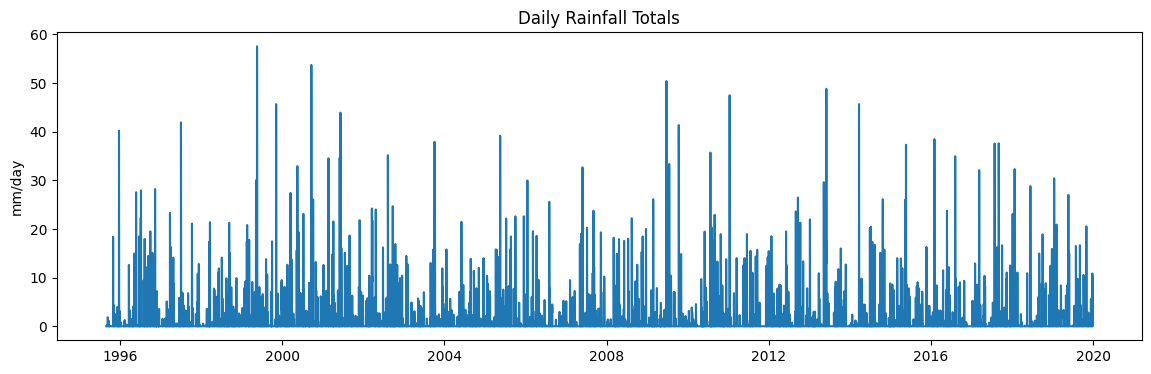

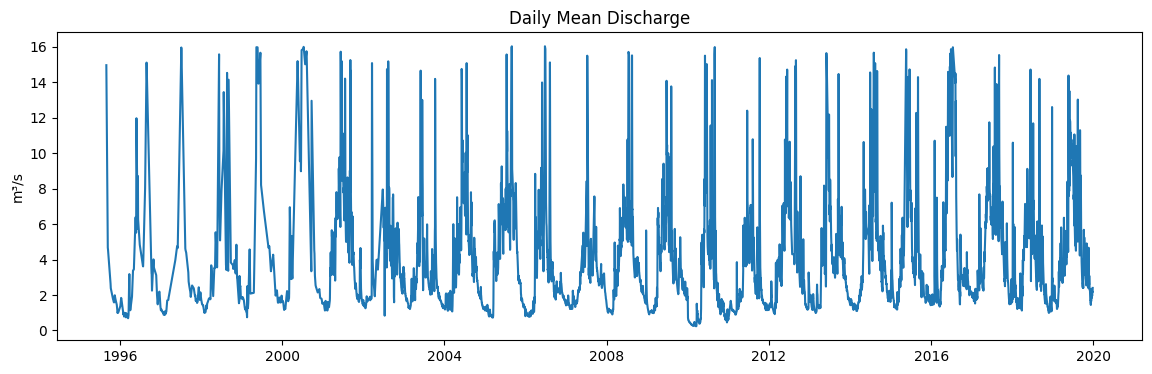

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(daily["date"], daily["pr_daily_sum"])
plt.title("Daily Rainfall Totals")
plt.ylabel("mm/day")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(daily["date"], daily["Q_daily_mean"])
plt.title("Daily Mean Discharge")
plt.ylabel("m³/s")
plt.show()


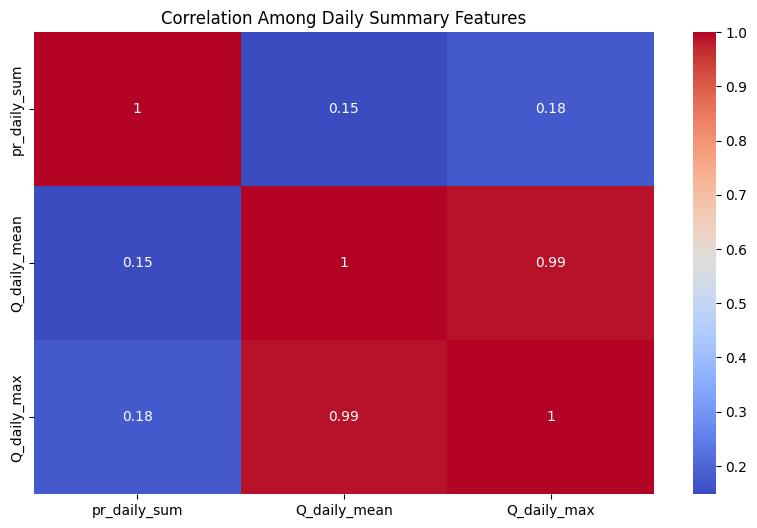

In [15]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(daily[["pr_daily_sum", "Q_daily_mean", "Q_daily_max"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Among Daily Summary Features")
plt.show()


In [16]:
HORIZON = 6  # days ahead

# Predict daily mean discharge 6 days later
daily["Q_future_6d"] = daily["Q_daily_mean"].shift(-HORIZON)


In [17]:
daily = daily.dropna().reset_index(drop=True)


In [18]:
# Feature columns: everything except the date and target
feature_cols = [col for col in daily.columns 
                if col not in ["date", "Q_future_6d"]]

X = daily[feature_cols]
y = daily["Q_future_6d"]

X.head()


,pr_00,pr_01,pr_02,pr_03,pr_04,pr_05,pr_06,pr_07,pr_08,pr_09,...,Q_17,Q_18,Q_19,Q_20,Q_21,Q_22,Q_23,pr_daily_sum,Q_daily_mean,Q_daily_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.767560,14.733910,14.700260,14.666611,14.632961,14.599311,14.565662,0.0,14.952633,15.339605
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.959967,13.926317,13.892668,13.859018,13.825368,13.791719,13.758069,0.0,14.145040,14.532012
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.152374,13.118725,13.085075,13.051425,13.017775,12.984126,12.950476,0.0,13.337448,13.724419
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.344781,12.311132,12.277482,12.243832,12.210183,12.176533,12.142883,0.0,12.529855,12.916826
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.537189,11.503539,11.469889,11.436240,11.402590,11.368940,11.335290,0.0,11.722262,12.109234


In [20]:
split = int(len(daily)*0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [21]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=25,
    min_samples_split=5,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=25, min_samples_split=5, n_estimators=400,
                      random_state=42)

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 1.9612679207955848
R²: 0.6468727069191933


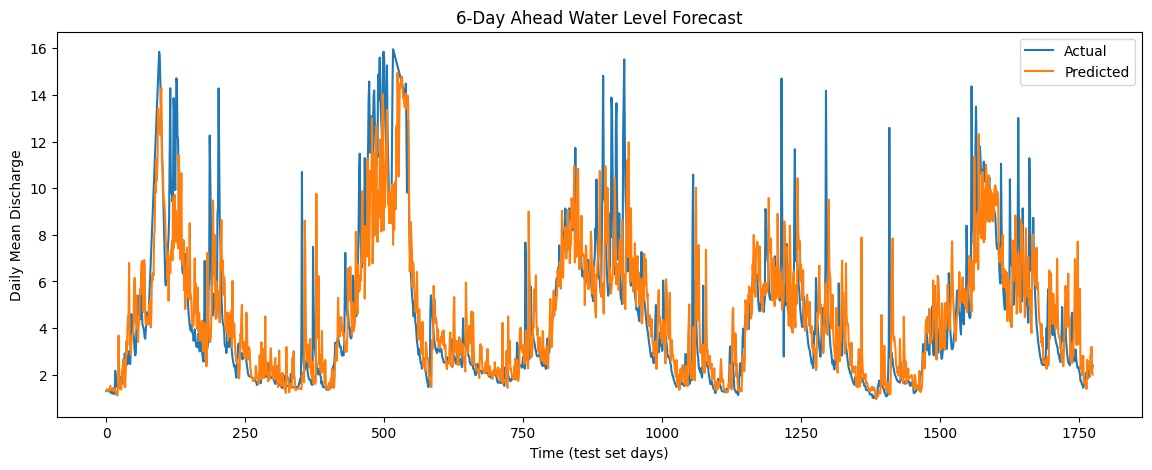

In [24]:
plt.figure(figsize=(14,5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("6-Day Ahead Water Level Forecast")
plt.xlabel("Time (test set days)")
plt.ylabel("Daily Mean Discharge")
plt.legend()
plt.show()


In [25]:
importances = pd.Series(model.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False).head(20)


Q_23            0.404954
Q_22            0.138610
Q_daily_max     0.082250
Q_20            0.062381
Q_21            0.061958
Q_18            0.033623
Q_19            0.021168
Q_16            0.015888
Q_00            0.014067
Q_daily_mean    0.012778
Q_17            0.012567
Q_14            0.008827
Q_01            0.008631
Q_15            0.008330
Q_03            0.007847
Q_06            0.007772
Q_04            0.007732
Q_08            0.007494
Q_07            0.007326
Q_09            0.007140
dtype: float64

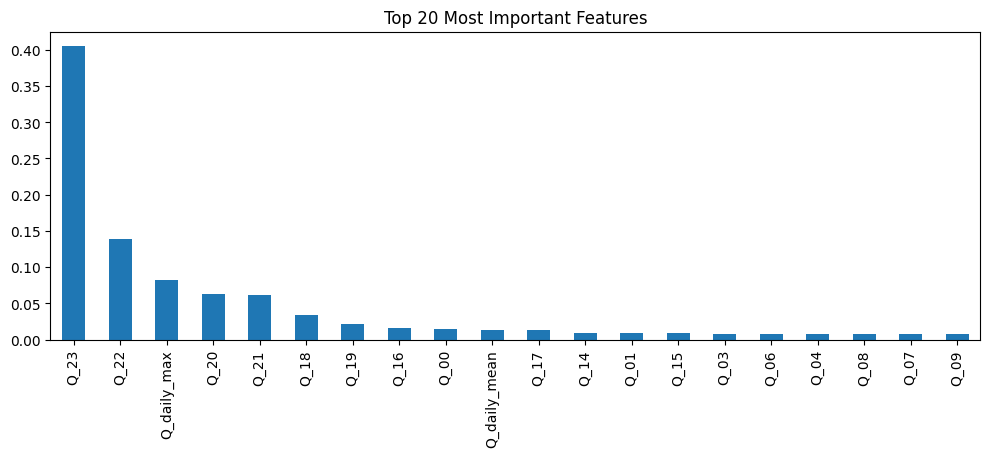

In [26]:
importances.sort_values(ascending=False).head(20).plot(kind="bar", figsize=(12,4))
plt.title("Top 20 Most Important Features")
plt.show()


In [27]:
def nse(sim, obs):
    return 1 - np.sum((obs-sim)**2) / np.sum((obs-np.mean(obs))**2)

print("NSE:", nse(y_pred, y_test.values))


NSE: 0.6468727069191933
